## Лабораторная работа № 3
-----

Необходимо реализовать фильтр калмана по сигма точкам для приведенного задания.

**Задача:** найти положение робота в 1D пространстве, при этом используем данные с камеры, измеряя высоту отдаленных
ориентиров относительно горизонта.<br />
**Замечание!**<br />
1.) Сохраним ту же модель линейного движения, что и в исходном примере, и предположим, что мы знаем высоту ориентира и его положение в глобальной системе координат.<br />
2.) Поскольку наш датчик измеряет угол, наша модель измерения имеет нелинейную зависимость от положения движущегося объекта.


<img src="https://likerobotics.ru/images/task2.jpg" width="400"/>

### Исходные данные 
Состояние
$$
\mathbf{x}=\left[\begin{array}{c}
p \\
\frac{d p}{d t}=\dot{p}
\end{array}\right]
$$
вход управления  $\quad \mathbf{u}=a=\frac{d^{2} p}{d t^{2}}$
<br />

Модель движения
$$
\begin{aligned}
\mathbf{x}_{k} &=\mathbf{f}\left(\mathbf{x}_{k-1}, \mathbf{u}_{k-1}, \mathbf{w}_{k-1}\right) \\
&=\left[\begin{array}{cc}
1 & \Delta t \\
0 & 1
\end{array}\right] \mathbf{x}_{k-1}+\left[\begin{array}{c}
0 \\
\Delta t
\end{array}\right] \mathbf{u}_{k-1}+\mathbf{w}_{k-1} \\
v_{k} & \sim \mathscr{N}(0,0.01) \quad \mathbf{w}_{k} \sim \mathscr{N}\left(\mathbf{0},(0.1) \mathbf{1}_{2 \times 2}\right)
\end{aligned}
$$

Модель измерения
$$
\begin{aligned}
y_{k} &=\phi_{k}=h\left(p_{k}, v_{k}\right) \\
&=\tan ^{-1}\left(\frac{S}{D-p_{k}}\right)+v_{k}
\end{aligned}
$$

Необходимо найти положение объекта в момент
времени 𝒌 + 𝟏, при ∆𝒕 = 𝟎. 𝟓 сек

$$
\begin{array}{cl}
\hat{\mathbf{x}}_{0} \sim \mathscr{N}\left(\left[\begin{array}{l}
0 \\
5
\end{array}\right],\right. & \left.\left[\begin{array}{cc}
0.01 & 0 \\
0 & 1
\end{array}\right]\right) \\
u_{0}=-2\left[\mathrm{~m} / \mathrm{s}^{2}\right] & y_{1}=\pi / 6[\mathrm{rad}] \\
S=20[\mathrm{~m}] & D=40[\mathrm{~m}]
\end{array}
$$

Подключаем необходимые библиотеки

In [49]:
import numpy as np
from numpy.linalg import inv, cholesky
import matplotlib.pyplot as plt

Задаем исходные данные:


In [50]:
x_0 = np.array([[0],[5]])
P_0 = np.array([[0.01 , 0],
                [0, 1]]) #ковариация в моментв ремени 0
Q_0 = np.array([[0.1 , 0],
                [0, 0.1]]) #ковариация модели движения в моментв ремени 0
R_0 = 0.01 #ковариация модели измерения в моментв ремени 0
u_0 = -2
y_1 = np.pi/6
S = 20
D = 40
dt = 0.5

### Начнем с предсказания
Для этого нам понадобится наша модель движения.

In [51]:

def motion_iterate(dt, x_k, u_k):
    """
    example inputs:
    dt = 0.5
    x_k = 0
    u_k = -2
    """
    # motion model 
    x_matrix = np.array([[1, dt], [0, 1]])
    u_matrix = np.array([[0], [dt]])
    x_k = x_matrix.dot(x_k) + u_matrix*u_k
    return x_k

Вспомнинаем, для N мерного распределения нам необходимо взять N+1 сигма точек.

In [52]:
#разложение Холецкого для ковариационной матрицы
N = 2 # размерность распределения
ka = 3 - N # каппа, значнеие для нормального распределения
hol = cholesky(P_0) 
print(hol)
#сигма точки нужно найти
sigma_list = []
sigma_list.append(x_0)
### START CODE HERE ###
for i in range(0, N):
    singma = x_0 + np.array(np.sqrt(N + ka) * hol[i,:]).reshape(2,1)
    sigma_list.append(singma)
for i in range(0, N):
    singma = x_0 - np.array(np.sqrt(N + ka) * hol[i,:]).reshape(2,1)
    sigma_list.append(singma)
### END CODE HERE ###
print(sigma_list)

[[0.1 0. ]
 [0.  1. ]]
[array([[0],
       [5]]), array([[0.17320508],
       [5.        ]]), array([[0.        ],
       [6.73205081]]), array([[-0.17320508],
       [ 5.        ]]), array([[0.        ],
       [3.26794919]])]


In [53]:
# теперь пропускаем наши сигма точки через нелинейную функцию (модель движения)
# чтобы получить сигма  точки для момента времени k
sigma_predicted = np.zeros((len(sigma_list), 2, 1))

for i, sigma in enumerate(sigma_list):
    sigma_predicted[i] = motion_iterate(0.5, sigma, -2)
    
print('Predicted sigma points: ', sigma_predicted)

Predicted sigma points:  [[[2.5       ]
  [4.        ]]

 [[2.67320508]
  [4.        ]]

 [[3.3660254 ]
  [5.73205081]]

 [[2.32679492]
  [4.        ]]

 [[1.6339746 ]
  [2.26794919]]]


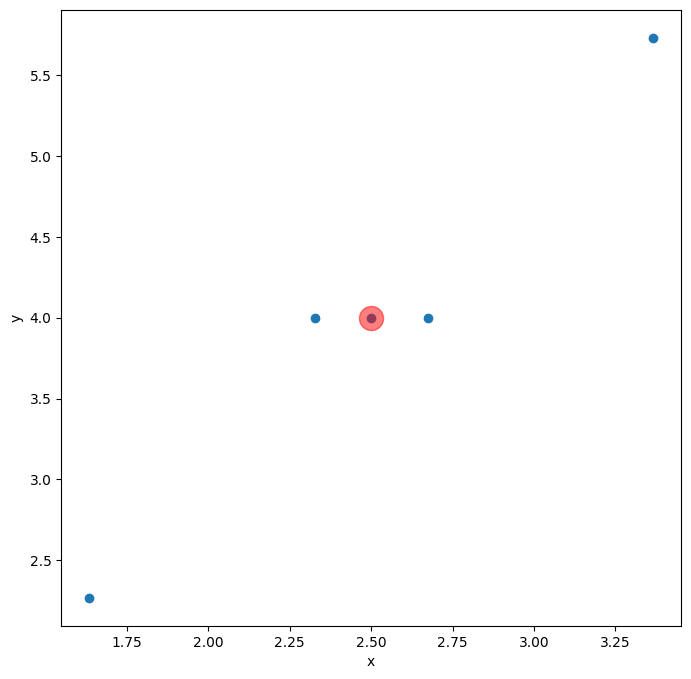

In [54]:
mean_x = sigma_predicted[:,0].mean(axis=0)
mean_y = sigma_predicted[:,1].mean(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(sigma_predicted[:,0], sigma_predicted[:,1])
plt.scatter(mean_x, mean_y, color='red', s=300, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Рачет парметров выходных данных(предсказанных): среднего и ковариации.

In [55]:
#коэффициенты надо посчитать
a_list = []
for i in range(2*N + 1):
    if i == 0:
        alpha = ka / (N + ka)
        a_list.append(alpha)
    else:
        alpha = 0.5 / (N + ka)
        a_list.append(alpha)
#инициализируем переменные для нового распределения
x_new = np.array([[0.0],[0.0]])
P_new = np.array([[0.0, 0.0],[0.0, 0.0]])

#среднее нового распределения
x_new = sum([a_list[i]*sigma_predicted[i] for i in range(2*N + 1)])
#ковариация нового распределения
P_new = sum(a_list[i]*(sigma_predicted[i] - x_new) * (sigma_predicted[i] - x_new).T for i in range(2*N + 1)) + Q_0
print("The new mean = ", x_new)
print("The new covariance = ", P_new)

The new mean =  [[2.5]
 [4. ]]
The new covariance =  [[0.36 0.5 ]
 [0.5  1.1 ]]


### Теперь, зная наше предсказание, когда мы сделаем измерение, мы сможем сделать поправку
аналогичная процедура, только на этот раз с нелинейной моделью измерения
$$
\hat{\mathbf{y}}_{k}^{(i)}=\mathbf{h}_{k}\left(\check{\mathbf{x}}_{k}^{(i)}, \mathbf{0}\right) \quad i=0 \ldots 2 N
$$

In [58]:
#разложение уже нашего P_new
hol = cholesky(P_new)
print(hol)

# аналогично находим сигма точки
cor_sigma_list = []
cor_sigma_list.append(x_new)
for i in range(0, N):
    singma = x_new + np.array(np.sqrt(N + ka) * hol[i,:]).reshape(2,1)
    cor_sigma_list.append(singma)
for i in range(0, N):
    singma = x_new - np.array(np.sqrt(N + ka) * hol[i,:]).reshape(2,1)
    cor_sigma_list.append(singma)
print(cor_sigma_list)


[[0.6        0.        ]
 [0.83333333 0.63683244]]
[array([[2.5],
       [4. ]]), array([[3.53923048],
       [4.        ]]), array([[3.94337567],
       [5.10302614]]), array([[1.46076952],
       [4.        ]]), array([[1.05662433],
       [2.89697386]])]


In [70]:
def measure_iterate(S,D,pk):
    """
    example inputs:
    S = 0.5
    D = 0
    p_k = -2
    """
    # motion model 
    y_k = np.arctan(S/(D-pk))
    return y_k

p_k = cor_sigma_list[0][0][0]
measure_iterate(S,D,p_k)

0.4899573262537283

In [71]:
# аналогично прогоняем через модель
sigma_mes_list = []
for i, sigma in enumerate(cor_sigma_list):
    sigma_mes_list.append(measure_iterate(S, D, sigma[0][0]))
print(sigma_mes_list)

[0.4899573262537283, 0.5017175820877777, 0.5064315663996093, 0.4786937816119785, 0.474441544612606]


Теперь считаем среднюю и ковариацию

In [73]:
#среднее нового распределения
y_new = sum([a_list[i]*sigma_mes_list[i] for i in range(2*N + 1)])
P_y_new = sum(a_list[i]*(sigma_mes_list[i] - y_new) * (sigma_mes_list[i] - y_new).T for i in range(2*N + 1)) + R_0
#..
print("The new mean = ", y_new)
print("The new covariance = ", P_y_new)

The new mean =  0.49019985453657133
The new covariance =  0.010129493033948377


Считаем  кросс ковариацию, усилитель калмана и получаем финальное значение оценки


In [74]:
P_xy = np.array([[0.0],[0.0]])
P_xy = sum(a_list[i]*(sigma_predicted[i] - x_new) * (sigma_mes_list[i] - y_new).T for i in range(2*N + 1))
print(P_xy)

[[0.005282  ]
 [0.00923472]]


In [75]:
#усилитель
K = P_xy*P_y_new
print(K)

[[5.35040004e-05]
 [9.35430709e-05]]


In [76]:
# финальная оценка после корректировки
x_1 = x_new + K * (y_1 - y_new)
print(x_1)

[[2.50000179]
 [4.00000312]]
